In [1]:
'''PART 1: STATISTICS FOR RANKS ON ABSORBED PAR.'''

import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scikit_posthocs as sp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import levene, shapiro
import numpy as np
from scipy.stats import sem, t


# Define the ANOVA function.
def process_anova(input_file, output_anova, output_assumptions, qqplot_path):
    # Load the data.
    data = pd.read_csv(input_file)

    # Open output files once at the start
    anova_output = open(output_anova, 'w')
    assumptions_output = open(output_assumptions, 'w')

    # Process data by rank.
    for rank in data['rank'].unique():
        # Filter data for the current rank.
        rank_data = data[data['rank'] == rank]

    # ANOVA model.
        model = ols('log_absorbedPAR_umol_m2_s1 ~ C(architecture)', data=rank_data).fit()
        anova_results = sm.stats.anova_lm(model, typ=2)

        # Function to format p-values with a minimum display value of 0.001
        def format_p_value(p):
            if p < 0.001:
                return "<0.001"
            else:
                return round(p, 3)

        # Apply the function to the ANOVA results' p-values
        anova_results['PR(>F)'] = anova_results['PR(>F)'].apply(format_p_value)

        # Write ANOVA results for this rank to the file
        anova_output.write(f"\nANOVA results for rank {rank}:\n{anova_results}\n")

            # Post-hoc test (TukeyHSD).
        if model.f_pvalue < 0.05:  # Check if the overall model is significant.
            posthoc = sp.posthoc_tukey_hsd(data['log_absorbedPAR_umol_m2_s1'], data['architecture'])
            posthoc = posthoc.map(lambda x: f"{x:.3f}")
            anova_output.write(f'\nPost-hoc (Tukeyhsd) Results:\n{posthoc}\n')

        # Assumption Checks: Levene's Test and Shapiro-Wilk Test for normality
        levene_stat, levene_p = levene(*[group['log_absorbedPAR_umol_m2_s1'] for name, group in data.groupby('architecture')])
        shapiro_stat, shapiro_p = shapiro(model.resid)
        
        # Write assumption test results for this rank
        assumptions_output.write(f'\nAssumptions for rank {rank}:\n')
        assumptions_output.write(f'Levene Test: Stat={levene_stat}, p={levene_p}\n')
        assumptions_output.write(f'Shapiro-Wilk Test: Stat={shapiro_stat}, p={shapiro_p}\n')

        # Plotting residuals for assumption checks.
        residuals = model.resid
        plt.figure()
        sm.qqplot(residuals, line='s')
        plt.title(f'Q-Q plot for residuals of rank {rank}')
        plt.savefig(f'{qqplot_path}_rank_{rank}.png')
        plt.close()

    # Close the output files after all ranks are processed
    anova_output.close()
    assumptions_output.close()


# Define input files and corresponding output paths
files = [
    {
        'input': 'log_transformed/combined_high_ranks_cleaned.csv',
        'output_anova': 'output_statistics/ANOVA_high_ranks.txt',
        'output_assumption': 'output_statistics/assumptions_high_ranks.txt',
        'qqplot': 'qq_plots/high_density_qqplot.png'
    },
    {
        'input': 'log_transformed/combined_low_ranks_cleaned.csv',
        'output_anova': 'output_statistics/ANOVA_low_ranks.txt',
        'output_assumption': 'output_statistics/assumptions_low_ranks.txt',
        'qqplot': 'qq_plots/low_density_qqplot.png'
    }
]

# Loop through each file and apply the ANOVA function
for file_info in files:
    process_anova(file_info['input'], file_info['output_anova'], file_info['output_assumption'], file_info['qqplot'])

print("ANOVA processing complete for all files.")





ANOVA processing complete for all files.


c:\Users\jacop\OneDrive\Desktop\Thesis\Data analysis\Statistics\venv\Lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [2]:
'''PART 2: LINE PLOT GENERATION FOR ABSORBED PAR ON EACH RANK.'''

import pandas as pd
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import sem, t

# Load datasets for high and low densities
data_high = pd.read_csv('combined_files/combined_high_ranks_cleaned.csv')
data_low = pd.read_csv('combined_files/combined_low_ranks_cleaned.csv')

# Function to calculate mean, std dev, and confidence intervals
def calculate_statistics(data, confidence=0.95):
    grouped = data.groupby(['architecture', 'rank'])['absorbedPAR_umol_m2_s1']
    mean_values = grouped.mean().reset_index(name='mean')
    mean_values['std_dev'] = grouped.std().reset_index(name='std_dev')['std_dev']
    mean_values['n'] = grouped.count().reset_index(name='count')['count']
    
    # Calculate the t-value for 95% confidence interval
    mean_values['t_value'] = mean_values['n'].apply(lambda x: t.ppf((1 + confidence) / 2., x - 1))
    
    # Calculate the margin of error
    mean_values['margin_error'] = mean_values['t_value'] * (mean_values['std_dev'] / np.sqrt(mean_values['n']))
    
    # Calculate lower and upper confidence bounds
    mean_values['ci_lower'] = mean_values['mean'] - mean_values['margin_error']
    mean_values['ci_upper'] = mean_values['mean'] + mean_values['margin_error']
    
    return mean_values

# Calculate statistics for both high-density and low-density datasets
mean_values_high = calculate_statistics(data_high)
mean_values_low = calculate_statistics(data_low)

# Plotting function to avoid repetition
def plot_absorbedPAR(mean_values, density_label, output_file):
    plt.figure(figsize=(10, 6))
    
    # Plotting lineplot for each architecture type within the current density
    for architecture in mean_values['architecture'].unique():
        architecture_data = mean_values[mean_values['architecture'] == architecture]
        sns.lineplot(x='rank', y='mean', data=architecture_data, label=architecture, marker='o')
        
        # Adding the confidence interval as a shaded area
        plt.fill_between(architecture_data['rank'], architecture_data['ci_lower'], architecture_data['ci_upper'], alpha=0.3)
    
    plt.title(f'Absorbed PAR over Leaf Ranks for {density_label} Density')
    plt.xlabel('Rank')
    plt.ylabel('Absorbed PAR (umol m-2 s-1)')
    plt.ylim(0, 300)
    plt.legend(title='Architecture Type')
    plt.savefig(output_file)
    plt.close()

# Plot for high-density data
plot_absorbedPAR(mean_values_high, 'High', 'plots/mean_absorbedPAR_for_high_density.png')

# Plot for low-density data
plot_absorbedPAR(mean_values_low, 'Low', 'plots/mean_absorbedPAR_for_low_density.png')

print("Plots generated successfully for high and low densities.")

Plots generated successfully for high and low densities.


    density   architecture  repetition  absorbedPAR_umol_m2_s1  area_m2[m^2]  \
0      High  architectureA           1              886.626033      0.050084   
1      High  architectureA           2              898.142581      0.050102   
2      High  architectureA           3              841.565563      0.050074   
3      High  architectureA           4              864.056255      0.050066   
4      High  architectureA           5              838.677274      0.050043   
..      ...            ...         ...                     ...           ...   
493    High        control          96              827.087922      0.050158   
494    High        control          97              797.928454      0.050116   
495    High        control          98              858.325426      0.050052   
496    High        control          99              801.242413      0.050085   
497    High        control         100              830.831216      0.049989   

     log_absorbedPAR_umol_m2_s1  
0    

<Figure size 640x480 with 0 Axes>

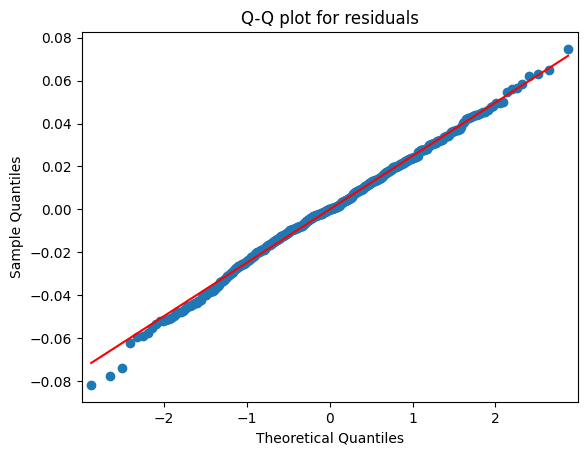

<Figure size 640x480 with 0 Axes>

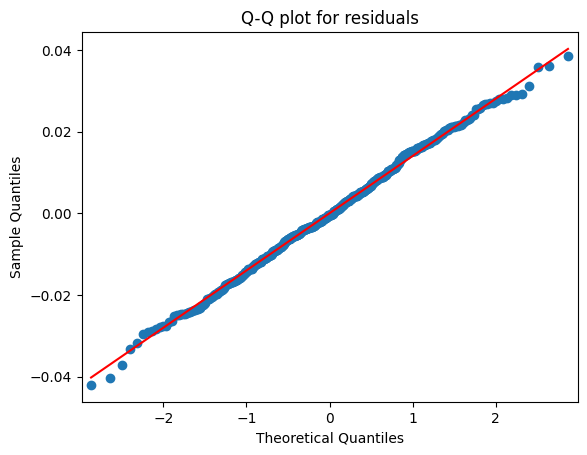

<Figure size 640x480 with 0 Axes>

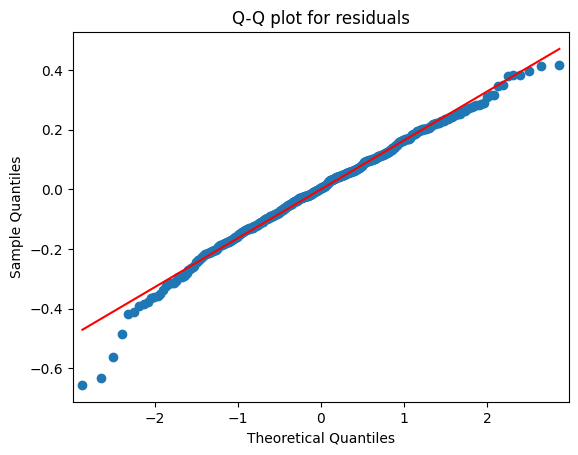

<Figure size 640x480 with 0 Axes>

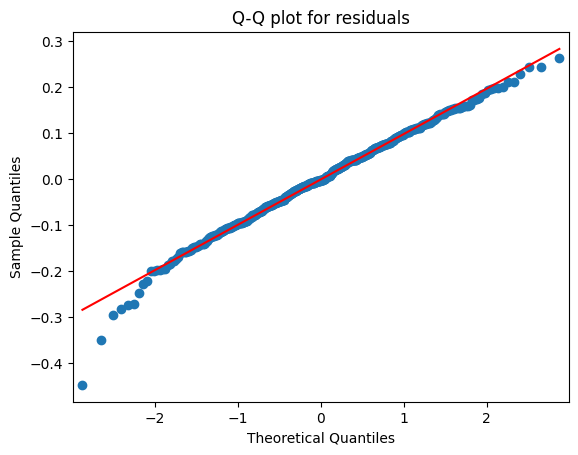

In [3]:
'''PART 3: STATISTICS ON TOTAL ABS PAR AND SENSORS.'''

import pandas as pd
import statsmodels.api as sm
import scikit_posthocs as sp
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
from scipy.stats import levene, shapiro


# Define a function to process ANOVA, assumptions, and plotting for each dataset.
def process_data(input_file, output_anova, output_assumptions, qqplot_path):
    # Load the data.
    data = pd.read_csv(input_file)
    print(data)

    # Create output.txt for anova results and assumptions.
    anova_output = open(output_anova, 'w')
    assumptions = open(output_assumptions, 'w')

    # ANOVA 1-way.
    model = ols('log_absorbedPAR_umol_m2_s1 ~ C(architecture)', data=data).fit()
    anova_results = sm.stats.anova_lm(model, typ=2)
    print(anova_results)

    # Function to format p-values with a minimum display value of 0.001
    def format_p_value(p):
        if p < 0.001:
            return "<0.001"
        else:
            return round(p, 3)

    # Apply the function to the ANOVA results' p-values
    anova_results['PR(>F)'] = anova_results['PR(>F)'].apply(format_p_value)

    # Get descriptive statistics.
    descriptive_statistics = data.describe()
    print(descriptive_statistics)

    # Write ANOVA results, model summary and descriptive statistics in txt file.
    anova_output.write(f"\nANOVA results for total absorbedPAR: \n {anova_results} \n")
    anova_output.write("\nModel summary: \n")
    anova_output.write(model.summary().as_text())
    anova_output.write(f"\nDescriptive statistics: {descriptive_statistics} \n")

    # Post-hoc test (TukeyHSD).
    if model.f_pvalue < 0.05:  # Check if the overall model is significant.
        # Perform Tukey HSD using statsmodels for an extensive comparison
        tukey = pairwise_tukeyhsd(data['log_absorbedPAR_umol_m2_s1'], data['architecture'], alpha=0.05)

        # Save Tukey HSD results to CSV
        tukey_hsd_file = output_anova.replace('ANOVA', 'Tukey_HSD').replace('.txt', '.csv')
        pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0]).to_csv(tukey_hsd_file, index=False)
        print(f"Tukey HSD results saved to {tukey_hsd_file}")
        
        # Write a more detailed Tukey HSD output to your text file
        anova_output.write('\nPost-hoc (Tukey HSD) Extensive Comparison Results:\n')
        anova_output.write(str(tukey.summary())) 

    # Assumption Checks: Levene's Test and Shapiro-Wilk Test for normality
    levene_stat, levene_p = levene(*[group['log_absorbedPAR_umol_m2_s1'] for name, group in data.groupby('architecture')])
    shapiro_stat, shapiro_p = shapiro(model.resid)
    assumptions.write(f'\nLevene Test: Stat={levene_stat}, p={levene_p}\n')
    assumptions.write(f'\nShapiro-Wilk Test: Stat={shapiro_stat}, p={shapiro_p}\n')

    # Plotting residuals for assumption checks.
    residuals = model.resid
    plt.figure()
    sm.qqplot(residuals, line='s')
    plt.title(f'Q-Q plot for residuals')
    plt.savefig(qqplot_path)

    # Close output files.
    anova_output.close()
    assumptions.close()


# Define input files and corresponding output paths for high and low densities.
files = [
    {
        'input_file': 'log_transformed/combined_total_absorbedPAR_high_cleaned.csv',
        'output_anova': 'output_statistics/ANOVA_total_absorbedPAR_high.txt',
        'output_assumptions': 'output_statistics/assumptions_total_absorbedPAR_high.txt',
        'qqplot_path': 'qq_plots/total_absorbedPAR_high.png',
    },
    {
        'input_file': 'log_transformed/combined_total_absorbedPAR_low_cleaned.csv',
        'output_anova': 'output_statistics/ANOVA_total_absorbedPAR_low.txt',
        'output_assumptions': 'output_statistics/assumptions_total_absorbedPAR_low.txt',
        'qqplot_path': 'qq_plots/total_absorbedPAR_low.png',
    },
        {
        'input_file': 'log_transformed/combined_high_sensors_cleaned.csv',
        'output_anova': 'output_statistics/ANOVA_sensors_high.txt',
        'output_assumptions': 'output_statistics/assumptions_sensors_high.txt',
        'qqplot_path': 'qq_plots/sensors_high.png',
    },
    {
        'input_file': 'log_transformed/combined_low_sensors_cleaned.csv',
        'output_anova': 'output_statistics/ANOVA_sensors_low.txt',
        'output_assumptions': 'output_statistics/assumptions_sensors_low.txt',
        'qqplot_path': 'qq_plots/sensors_low.png',
    }
]

# Loop through the files and apply the function to each file
for file_info in files:
    process_data(
        input_file=file_info['input_file'],
        output_anova=file_info['output_anova'],
        output_assumptions=file_info['output_assumptions'],
        qqplot_path=file_info['qqplot_path'],
    )

print("Analysis completed for both datasets.")




In [4]:
'''PART 4: BAR PLOT OF TOTAL ABS PAR FOR PLANTS AND SENSORS'''

import pandas as pd
import matplotlib.pyplot as plt

# Load datasets for high and low densities
data_high_totalPAR_plants = pd.read_csv('combined_files/combined_total_absorbedPAR_high_cleaned.csv')
data_low_totalPAR_plants = pd.read_csv('combined_files/combined_total_absorbedPAR_low_cleaned.csv')
data_high_sensors = pd.read_csv('combined_files/combined_high_sensors_cleaned.csv')
data_low_sensors = pd.read_csv('combined_files/combined_low_sensors_cleaned.csv')


# Function to calculate mean, std dev, and confidence intervals
def calculate_statistics(data):
    grouped = data.groupby(['architecture'])['absorbedPAR_umol_m2_s1']
    mean_values = grouped.mean().reset_index(name='mean')
    mean_values['std_dev'] = grouped.std().reset_index(name='std_dev')['std_dev']
    mean_values['n'] = grouped.count().reset_index(name='count')['count']
        
    return mean_values

# Calculate statistics for both high-density and low-density datasets
mean_values_high_totalPAR_plants = calculate_statistics(data_high_totalPAR_plants)
mean_values_low_totalPAR_plants = calculate_statistics(data_low_totalPAR_plants)
mean_values_high_sensors = calculate_statistics(data_high_sensors)
mean_values_low_sensors = calculate_statistics(data_low_sensors)

# Plotting function to avoid repetition
def barplot_absorbedPAR(mean_values, density_label, output_file):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plotting lineplot for each architecture type within the current density
    for architecture in mean_values['architecture'].unique():
        architecture_data = mean_values[mean_values['architecture'] == architecture]
        ax.bar(architecture_data['architecture'], architecture_data['mean'], yerr=architecture_data['std_dev'], 
        width=0.5, edgecolor='black', linewidth=0.5, capsize=5, color='green')

    # Set the title and labels
    ax.set_title(f'Total Absorbed PAR for {density_label} density')
    ax.set_xlabel('Architecture')
    ax.set_ylim(0, 1400)
    ax.set_ylabel('Absorbed PAR (umol m-2 s-1)')

    plt.savefig(output_file)
    plt.close(fig)


# Call the barplot function.
barplot_absorbedPAR(mean_values_high_totalPAR_plants, 'High', 'plots/total_absorbedPAR_high_density.png')
barplot_absorbedPAR(mean_values_low_totalPAR_plants, 'Low', 'plots/total_absorbedPAR_low_density.png')
barplot_absorbedPAR(mean_values_high_sensors, 'High', 'plots/sensors_high_density.png')
barplot_absorbedPAR(mean_values_low_sensors, 'Low', 'plots/sensors_low_density.png')

print("Plots generated successfully for high and low densities.")

Plots generated successfully for high and low densities.
